In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import matplotlib.pyplot as plt
import re
import json

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## COCO

In [ ]:
zip_path = '/content/drive/My Drive/GNLP/val2017.zip'

In [ ]:
!ls "{zip_path}"

'/content/drive/My Drive/GNLP/val2017.zip'


In [ ]:
# Create a directory to extract to
!mkdir -p /content/coco

In [ ]:
!unzip "{zip_path}" -d /content/coco

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/val2017/000000212226.jpg  
 extracting: /content/coco/val2017/000000231527.jpg  
 extracting: /content/coco/val2017/000000578922.jpg  
 extracting: /content/coco/val2017/000000062808.jpg  
 extracting: /content/coco/val2017/000000119038.jpg  
 extracting: /content/coco/val2017/000000114871.jpg  
 extracting: /content/coco/val2017/000000463918.jpg  
 extracting: /content/coco/val2017/000000365745.jpg  
 extracting: /content/coco/val2017/000000320425.jpg  
 extracting: /content/coco/val2017/000000481404.jpg  
 extracting: /content/coco/val2017/000000314294.jpg  
 extracting: /content/coco/val2017/000000335328.jpg  
 extracting: /content/coco/val2017/000000513688.jpg  
 extracting: /content/coco/val2017/000000158548.jpg  
 extracting: /content/coco/val2017/000000132116.jpg  
 extracting: /content/coco/val2017/000000415238.jpg  
 extracting: /content/coco/val2017/000000321333.jpg  
 extracting: /content/coco/val2

In [ ]:
import random
# Get Subset dataset
coco_folder = "/content/coco/val2017"
random.seed(42)  # Set seed

all_files = sorted([f for f in os.listdir(coco_folder) if f.endswith(".jpg")])
num_images = 500
random.shuffle(all_files)
image_files = all_files[:num_images]

### To load currect images :(

In [ ]:
coco_folder = "/content/coco/val2017"
# Load the CSV
csv_path = "vlm_flip_symmetry_results.csv"
df = pd.read_csv(csv_path)

# Extract the 'Image' column as a list
image_files = df["Image"].tolist()

In [ ]:
len(image_files)

500

In [ ]:
image_files[0]

'000000009483.jpg'

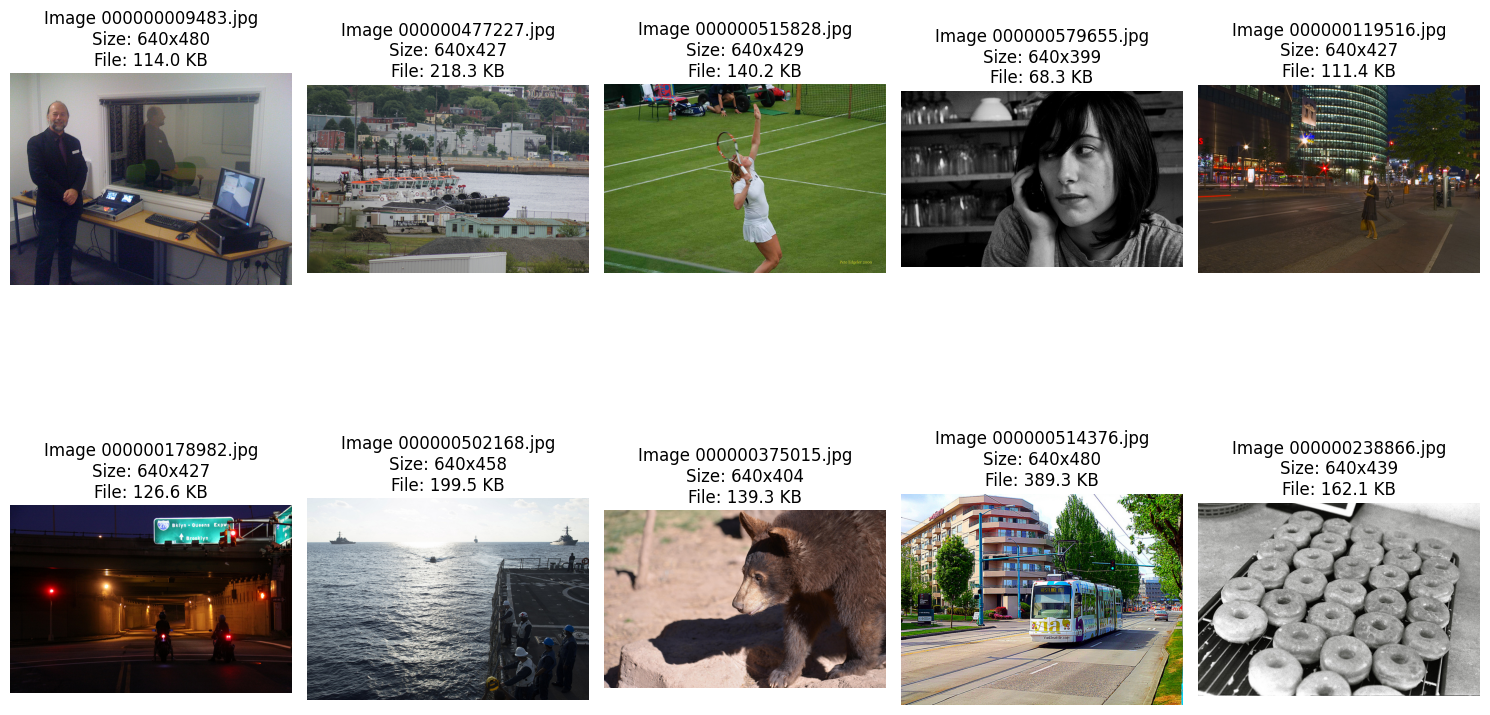

In [ ]:
# Plot first 10 images
fig = plt.figure(figsize=(15, 10))

for i, img_file in enumerate(image_files[:10]):
    img_path = os.path.join(coco_folder, img_file)

    # Get file size in KB
    file_size_kb = os.path.getsize(img_path) / 1024

    img = Image.open(img_path)
    width, height = img.size
    img_array = np.array(img)

    # Create subplot
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img)
    ax.set_title(f"Image {img_file}\nSize: {width}x{height}\nFile: {file_size_kb:.1f} KB")
    ax.axis('off')

plt.tight_layout()
plt.show()

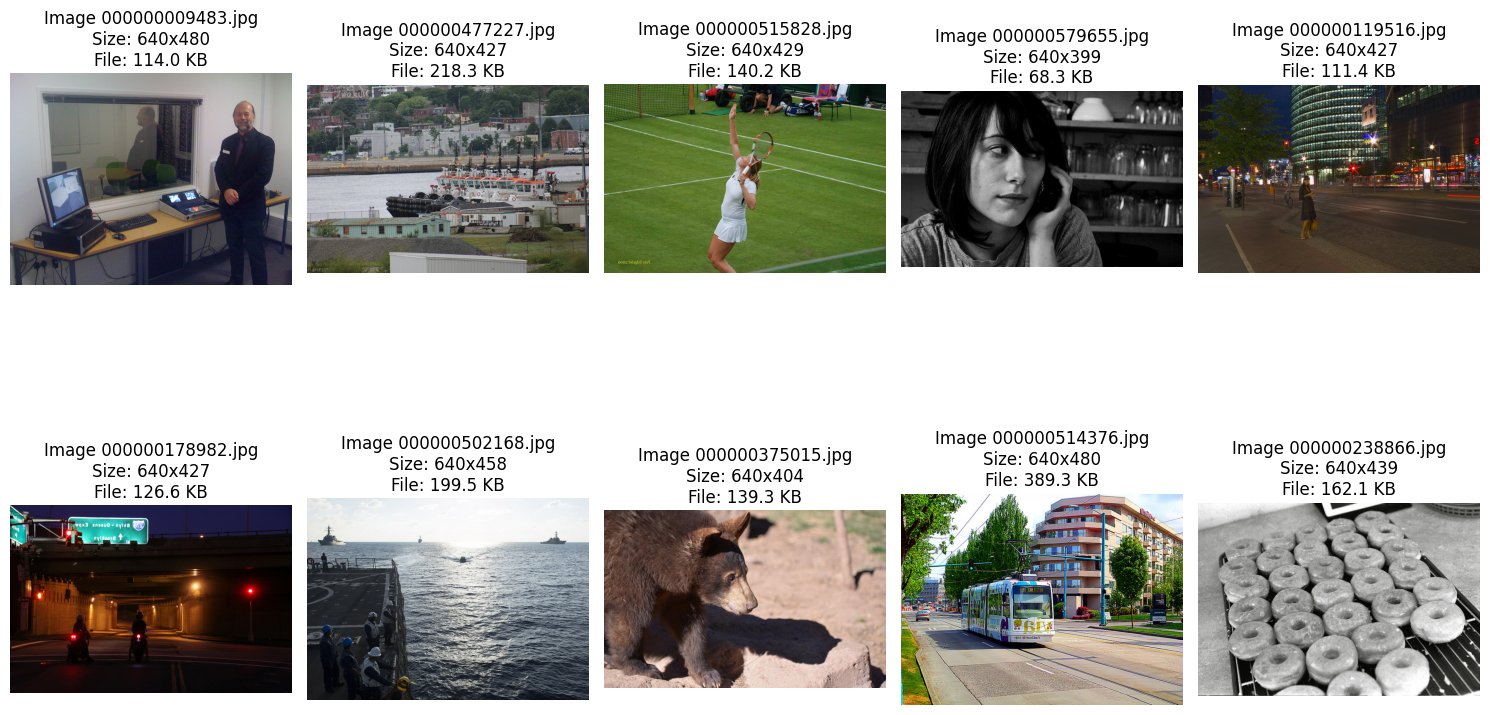

In [ ]:
# Plot first 10 images
fig = plt.figure(figsize=(15, 10))

for i, img_file in enumerate(image_files[:10]):
    img_path = os.path.join(coco_folder, img_file)

    # Get file size in KB
    file_size_kb = os.path.getsize(img_path) / 1024

    img = Image.open(img_path)
    img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
    width, height = img_flipped.size
    img_array = np.array(img_flipped)

    # Create subplot
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img_flipped)
    ax.set_title(f"Image {img_file}\nSize: {width}x{height}\nFile: {file_size_kb:.1f} KB")
    ax.axis('off')

plt.tight_layout()
plt.show()

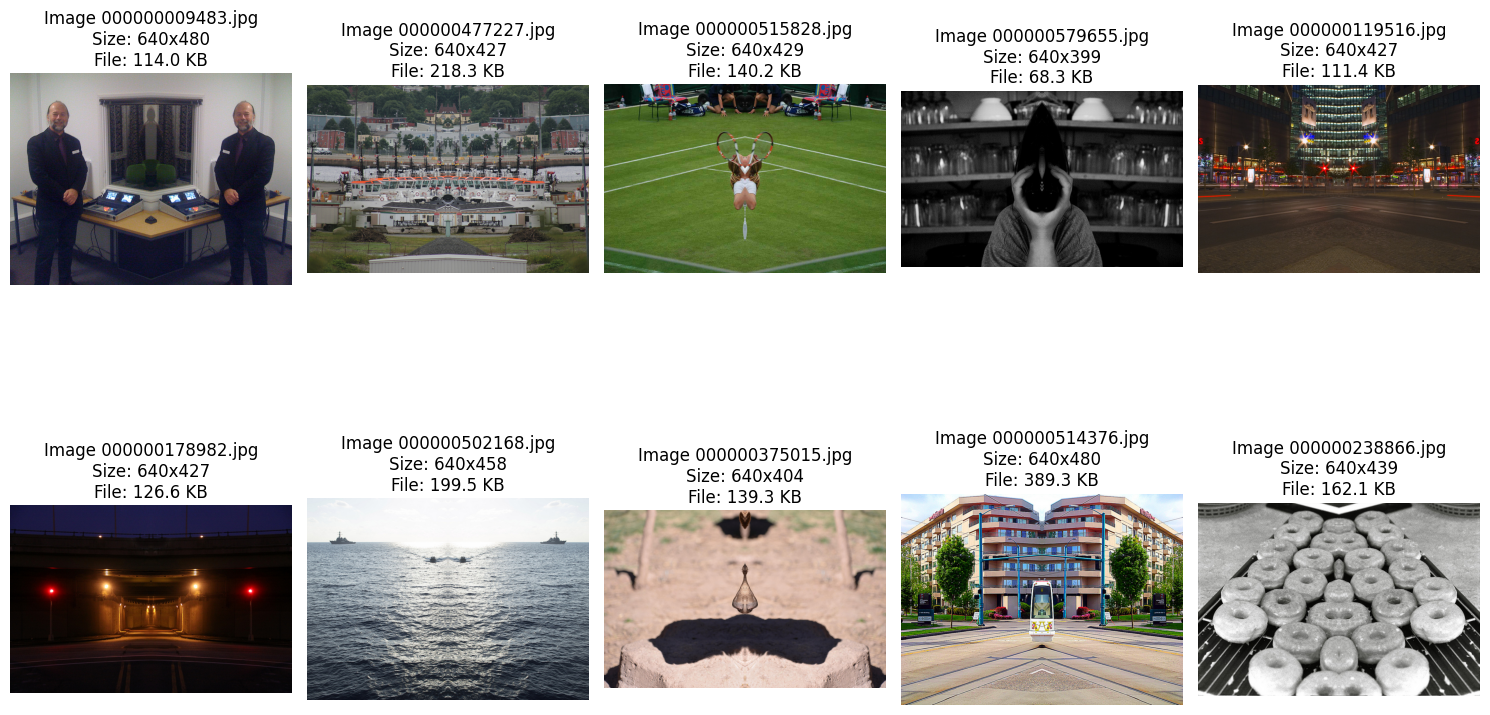

In [ ]:
# Plot first 10 images
fig = plt.figure(figsize=(15, 10))

for i, img_file in enumerate(image_files[:10]):
    img_path = os.path.join(coco_folder, img_file)

    # Get file size in KB
    file_size_kb = os.path.getsize(img_path) / 1024

    img = Image.open(img_path)
    img_sym = make_horizontal_mirror(img)

    width, height = img_sym.size
    img_array = np.array(img_sym)

    # Create subplot
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img_sym)
    ax.set_title(f"Image {img_file}\nSize: {width}x{height}\nFile: {file_size_kb:.1f} KB")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Install necessary packages
!pip install --upgrade bitsandbytes
!pip install --upgrade transformers accelerate
!pip install --upgrade scipy safetensors

In [ ]:
import bitsandbytes as bnb
print(bnb.__version__)

0.45.5


# LLava 1.5-7B and LLava 1.5-13B

In [ ]:
# Set model cache directory
cache_dir = "/content/llava_cache"

from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
import torch

# Use 8-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True
)

# Set model ID and load processor + model
# model_id = "llava-hf/llava-1.5-7b-hf" # llava 1.5 7B
model_id = "llava-hf/llava-1.5-13b-hf" # llava 1.5 13B
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
type(model)

transformers.models.llava.modeling_llava.LlavaForConditionalGeneration

In [ ]:
print(model_id)

llava-hf/llava-1.5-13b-hf


In [ ]:
image_files

['000000009483.jpg',
 '000000477227.jpg',
 '000000515828.jpg',
 '000000579655.jpg',
 '000000119516.jpg',
 '000000178982.jpg',
 '000000502168.jpg',
 '000000375015.jpg',
 '000000514376.jpg',
 '000000238866.jpg',
 '000000270386.jpg',
 '000000414510.jpg',
 '000000539883.jpg',
 '000000195045.jpg',
 '000000221291.jpg',
 '000000205542.jpg',
 '000000521141.jpg',
 '000000570471.jpg',
 '000000284282.jpg',
 '000000260266.jpg',
 '000000169996.jpg',
 '000000327306.jpg',
 '000000496722.jpg',
 '000000201418.jpg',
 '000000389315.jpg',
 '000000492282.jpg',
 '000000170613.jpg',
 '000000463618.jpg',
 '000000244496.jpg',
 '000000361142.jpg',
 '000000087244.jpg',
 '000000154425.jpg',
 '000000030494.jpg',
 '000000544306.jpg',
 '000000124636.jpg',
 '000000500477.jpg',
 '000000297427.jpg',
 '000000464144.jpg',
 '000000395633.jpg',
 '000000174231.jpg',
 '000000231169.jpg',
 '000000291664.jpg',
 '000000571804.jpg',
 '000000552902.jpg',
 '000000182923.jpg',
 '000000291619.jpg',
 '000000220584.jpg',
 '00000052288

## **Symmetry: Object Recognition**

Task:
- Use a VLM to list the objects in the image
- Flip the image from left to right and get new list of objects in the image
- Compare both lists

In [ ]:
# Previous prompts:
# prompt_template = "<image> What objects do you see in the image? List them separated by semicolons."
# prompt_template = "Describe this image <image>"
# prompt_template = "<image>\nTask: Describe this image in detail.\nProvide at least 3 sentences about what you see.\nBe specific and thorough."
# prompt_template = "USER: <image>\nWhat are the object that can be seen in this image? Can you list them (only that and separated by commas, don't include anything else)?\nASSISTANT:"

In [ ]:
# Get objects from VLM response
def get_object_list(response):
    # Remove prompt-related prefixes
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1]
    elif "ASSISTANT" in response:
        response = response.split("ASSISTANT")[-1]

    # Clean punctuation, tokenize, normalize
    cleaned = re.sub(r"[^\w\s,]", "", response)
    objects = set([obj.strip().lower() for obj in cleaned.split(",") if obj.strip()])
    return objects

# Compare the two lists of objects
def compare_object_lists(objs, objs_flipped):
    intersection = objs & objs_flipped
    union = objs | objs_flipped

    return {
        "#Objects_Original": len(objs),
        "#Objects_Flipped": len(objs_flipped),
        "#Shared": len(intersection),
        "Jaccard": round(len(intersection) / len(union), 3) if union else 1.0,
        "ExactMatch": objs == objs_flipped,
        "MissingInFlipped": list(objs - objs_flipped),
        "ExtraInFlipped": list(objs_flipped - objs),
        "OriginalSet": objs,
        "FlippedSet": objs_flipped
    }

In [ ]:
prompt_template = "USER: <image>\nWhat objects are visible in the image? Respond with a flat list of object names only, separated by commas (no extra description or full sentences).\nASSISTANT"
csv_path = "llava_13b_flip_obj_list.csv"
outputs = []

i = 1
for file_name in image_files:
    image_path = os.path.join(coco_folder, file_name)

    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    inputs = processor(images=img_pil, text=prompt_template, return_tensors="pt").to("cuda", torch.float16)

    output = model.generate(
      **inputs,
      max_new_tokens=100,
      do_sample=False
    )

    decoded = processor.batch_decode(output, skip_special_tokens=True)[0]

    # Clean response (remove echoing prompt)
    cleaned = decoded.replace(prompt_template.replace("<image>", "").strip(), "").strip()

    objs = get_object_list(cleaned)

    # Now, using flipped image
    img_pil_flipped = img_pil.transpose(method=Image.FLIP_LEFT_RIGHT)

    inputs_flipped = processor(images=img_pil_flipped, text=prompt_template, return_tensors="pt").to("cuda", torch.float16)
    output_flipped = model.generate(
      **inputs_flipped,
      max_new_tokens=100,
      do_sample=False
    )

    decoded_flipped = processor.batch_decode(output_flipped, skip_special_tokens=True)[0]

    # Clean response (remove echoing prompt)
    cleaned_flipped = decoded_flipped.replace(prompt_template.replace("<image>", "").strip(), "").strip()

    objs_flipped = get_object_list(cleaned_flipped)

    comparison = compare_object_lists(objs, objs_flipped)

    comparison.update({
      "Image": file_name
    })

    outputs.append(comparison)


    # Append to CSV
    df = pd.DataFrame([comparison])  # wrap in list to make a 1-row dataframe
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df.to_csv(csv_path, mode="a", index=False, header=False)

    torch.cuda.empty_cache()
    print(f"Processed {file_name} ", i, "/", len(image_files))
    i += 1

Processed 000000009483.jpg  1 / 500
Processed 000000477227.jpg  2 / 500
Processed 000000515828.jpg  3 / 500
Processed 000000579655.jpg  4 / 500
Processed 000000119516.jpg  5 / 500
Processed 000000178982.jpg  6 / 500
Processed 000000502168.jpg  7 / 500
Processed 000000375015.jpg  8 / 500
Processed 000000514376.jpg  9 / 500
Processed 000000238866.jpg  10 / 500
Processed 000000270386.jpg  11 / 500
Processed 000000414510.jpg  12 / 500
Processed 000000539883.jpg  13 / 500
Processed 000000195045.jpg  14 / 500
Processed 000000221291.jpg  15 / 500
Processed 000000205542.jpg  16 / 500
Processed 000000521141.jpg  17 / 500
Processed 000000570471.jpg  18 / 500
Processed 000000284282.jpg  19 / 500
Processed 000000260266.jpg  20 / 500
Processed 000000169996.jpg  21 / 500
Processed 000000327306.jpg  22 / 500
Processed 000000496722.jpg  23 / 500
Processed 000000201418.jpg  24 / 500
Processed 000000389315.jpg  25 / 500
Processed 000000492282.jpg  26 / 500
Processed 000000170613.jpg  27 / 500
Processed 

KeyboardInterrupt: 

## Symmetry: Is this image symmetrical?
Task:
- Create images where they are symmetrical
- See if VLM can detect these symmetrical images

In [ ]:
# Create symmetrical image
def make_horizontal_mirror(img_pil):
    width, height = img_pil.size
    left_half = img_pil.crop((0, 0, width // 2, height))
    mirrored_right = left_half.transpose(Image.FLIP_LEFT_RIGHT)

    new_img = Image.new('RGB', (width, height))
    new_img.paste(left_half, (0, 0))
    new_img.paste(mirrored_right, (width // 2, 0))

    return new_img

def get_ground_truth(response, is_symmetrical):
    # Remove "ASSISTANT" prefix
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1]
    elif "ASSISTANT" in response:
        response = response.split("ASSISTANT")[-1]

    response = response.strip().lower()
    response = re.sub(r"[^\w\s]", "", response)  # remove punctuation

    # Check for "yes" / "no"
    if "yes" in response:
        return (1 if is_symmetrical else 0), response
    elif "no" in response:
        return (0 if is_symmetrical else 1), response
    elif "unclear" in response:
        return -1, response
    else:
        return -1, response  # default to unclear

In [ ]:
sym_prompt_template = "USER: <image>\nIs this image symmetrical along the vertical axis? In other words, is the left half of the image a mirror of the right half? Respond with only 'Yes' or 'No' or 'Unclear'.\nASSISTANT:"
csv_path = "llava13b_symmetry_detection.csv"
outputs = []

import traceback

for i, file_name in enumerate(image_files, start=1):
    try:
        image_path = os.path.join(coco_folder, file_name)

        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        # Prompt original
        inputs = processor(images=img_pil, text=sym_prompt_template, return_tensors="pt").to("cuda", torch.float16)
        output = model.generate(**inputs, max_new_tokens=100, do_sample=False)
        decoded = processor.batch_decode(output, skip_special_tokens=True)[0]
        cleaned = decoded.replace(sym_prompt_template.replace("<image>", "").strip(), "").strip()
        print('Cleaned: ', cleaned)
        val_normal, normal_response = get_ground_truth(cleaned, False)

        # Mirror and prompt again
        img_sym = make_horizontal_mirror(img_pil)
        inputs_sym = processor(images=img_sym, text=sym_prompt_template, return_tensors="pt").to("cuda", torch.float16)
        output_sym = model.generate(**inputs_sym, max_new_tokens=100, do_sample=False)
        decoded_sym = processor.batch_decode(output_sym, skip_special_tokens=True)[0]
        cleaned_sym = decoded_sym.replace(sym_prompt_template.replace("<image>", "").strip(), "").strip()
        print('cleaned sym: ', cleaned_sym)
        val_sym, sym_response = get_ground_truth(cleaned_sym, True)

        # Save result
        comparison = {
            "Image": file_name,
            "Normal": val_normal,
            "Normal_Raw": normal_response,
            "Symmetrical": val_sym,
            "Symmetrical_Raw": sym_response
        }

        outputs.append(comparison)

        df = pd.DataFrame([comparison])
        if not os.path.exists(csv_path):
            df.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, mode="a", index=False, header=False)

        torch.cuda.empty_cache()
        print(f"Processed {file_name} ({i}/{len(image_files)})")

    except Exception as e:
        print(f"Error on file {file_name}: {e}")
        traceback.print_exc()

Cleaned:  USER:  
Is this image symmetrical along the vertical axis? In other words, is the left half of the image a mirror of the right half? Respond with only 'Yes' or 'No' or 'Unclear'.
ASSISTANT: Yes
cleaned sym:  USER:  
Is this image symmetrical along the vertical axis? In other words, is the left half of the image a mirror of the right half? Respond with only 'Yes' or 'No' or 'Unclear'.
ASSISTANT: Yes
Processed 000000009483.jpg (1/500)
Cleaned:  USER:  
Is this image symmetrical along the vertical axis? In other words, is the left half of the image a mirror of the right half? Respond with only 'Yes' or 'No' or 'Unclear'.
ASSISTANT: Yes
cleaned sym:  USER:  
Is this image symmetrical along the vertical axis? In other words, is the left half of the image a mirror of the right half? Respond with only 'Yes' or 'No' or 'Unclear'.
ASSISTANT: Yes
Processed 000000477227.jpg (2/500)
Cleaned:  USER:  
Is this image symmetrical along the vertical axis? In other words, is the left half of t

## Sentiment analysis (Will not be used)

In [ ]:
# Clean response
def clean_response(response: str) -> str:
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1]
    elif "ASSISTANT" in response:
        response = response.split("ASSISTANT")[-1]
    return response.strip()

In [ ]:
from openai import OpenAI

client = OpenAI(api_key = api_key)

def clean_response(response: str) -> str:
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1]
    elif "ASSISTANT" in response:
        response = response.split("ASSISTANT")[-1]
    return response.strip()

def compare_responses(response_original: str, response_flipped: str) -> dict:
    original = clean_response(response_original)
    flipped = clean_response(response_flipped)

    user_prompt = f"""
      You are evaluating whether two image descriptions (with emphasis on spatial reasoning) refer to the same scene.
      The second image is a horizontal flip of the first (flipped from left to right).

      Original:
      {original}

      Flipped:
      {flipped}

      Please answer the following questions:

      1. Do both descriptions refer to the same scene (same objects and layout, ignoring direction)?
      Respond with <Yes> if the content is clearly about the same scene even if spatial directions differ. Otherwise respond No.

      2. Is the spatial reasoning consistent with the horizontal flip?
      For example, if the original says <A is to the left of B>, the flipped should say <A is to the right of B>.
      If objects are described as being in the center in both cases, that's also correct.
      Respond with <Yes> if spatial directions are correctly mirrored, or <No> if they are not.

      3. On a scale from 1 to 5, how well is the spatial reasoning preserved?
      - 5 = All spatial relationships are flipped or preserved correctly (including center).
      - 1 = Most or all spatial relationships are incorrect or contradictory.

      4. Briefly explain your reasoning on how the spatial reasoning is preserved or not preserved.

      Respond with this exact format (no explanations):
      1. Yes/No
      2. Yes/No
      3. [1–5]
      4. Explanation
    """

    print('User prompt: ', user_prompt)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that evaluates spatial and semantic similarity in image descriptions."},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.2,
        max_tokens=200,
    )

    content = response.choices[0].message.content.strip()
    # print('Response:', content)

    # Try parsing the 4 responses from the LLM output
    lines = content.splitlines()
    if len(lines) >= 4:
        return {
            "Q1_Scene_Match": lines[0].strip().replace("<", "").replace(">", ""),
            "Q2_Spatial_Consistency": lines[1].strip().replace("<", "").replace(">", ""),
            "Q3_Spatial_Score": lines[2].strip(),
            "Q4_Explanation": lines[3].strip(),
            "Original_Description": original,
            "Flipped_Description": flipped
        }
    else:
        return {
            "Q1_Scene_Match": "PARSE_ERROR",
            "Q2_Spatial_Consistency": "PARSE_ERROR",
            "Q3_Spatial_Score": "PARSE_ERROR",
            "Q4_Explanation": content,
            "Original_Description": original,
            "Flipped_Description": flipped
        }

In [ ]:
# Sentiment Analysis
prompt_template = f"""USER: <image>\nDescribe what you see in this image with a focus on spatial relationships between the main objects.
Use directional terms like on the left, to the right, in the center, above, or below to explain how objects are arranged relative to each other.
Mention where the important objects are located in the scene and how they are positioned in relation to each other.
Write your response as a short paragraph.\nASSISTANT"""

csv_path = "vlm_flip_symmetry_sentiment.csv"
outputs = []

i = 1
for file_name in image_files[:200]:
    image_path = os.path.join(coco_folder, file_name)

    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    inputs = processor(images=img_pil, text=prompt_template, return_tensors="pt").to("cuda", torch.float16)

    output = model.generate(
      **inputs,
      max_new_tokens=200,
      do_sample=False
    )

    decoded = processor.batch_decode(output, skip_special_tokens=True)[0]

    # Clean response (remove echoing prompt)
    cleaned = decoded.replace(prompt_template.replace("<image>", "").strip(), "").strip()

    # Now, using flipped image
    img_pil_flipped = img_pil.transpose(method=Image.FLIP_LEFT_RIGHT)

    inputs_flipped = processor(images=img_pil_flipped, text=prompt_template, return_tensors="pt").to("cuda", torch.float16)
    output_flipped = model.generate(
      **inputs_flipped,
      max_new_tokens=200,
      do_sample=False
    )

    decoded_flipped = processor.batch_decode(output_flipped, skip_special_tokens=True)[0]

    # Clean response (remove echoing prompt)
    cleaned_flipped = decoded_flipped.replace(prompt_template.replace("<image>", "").strip(), "").strip()

    comparison = compare_responses(cleaned, cleaned_flipped)

    comparison.update({
      "Image": file_name
    })

    outputs.append(comparison)

    # Append to CSV
    df = pd.DataFrame([comparison])  # wrap in list to make a 1-row dataframe
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df.to_csv(csv_path, mode="a", index=False, header=False)

    torch.cuda.empty_cache()
    print(f"Processed {file_name} ", i, "/", len(image_files))
    i += 1

Streaming output truncated to the last 5000 lines.
      Respond with <Yes> if spatial directions are correctly mirrored, or <No> if they are not.

      3. On a scale from 1 to 5, how well is the spatial reasoning preserved?
      - 5 = All spatial relationships are flipped or preserved correctly (including center).
      - 1 = Most or all spatial relationships are incorrect or contradictory.

      4. Briefly explain your reasoning on how the spatial reasoning is preserved or not preserved.

      Respond with this exact format (no explanations):
      1. Yes/No
      2. Yes/No
      3. [1–5]
      4. Explanation
    
Processed 000000093437.jpg  49 / 500
User prompt:  
      You are evaluating whether two image descriptions (with emphasis on spatial reasoning) refer to the same scene.
      The second image is a horizontal flip of the first (flipped from left to right).

      Original:
      In the image, a large pot filled with a red sauce is placed on a stove. A wooden spoon is in

## COCO GT

In [ ]:
!pip install pycocotools

import os
import json
import random
from pycocotools.coco import COCO

In [ ]:
from collections import Counter
# Paths
annotation_file = 'instances_val2017.json'
image_dir = 'coco/val2017'

# Load COCO
coco = COCO(annotation_file)

# Map: file_name → image_id
file_name_to_id = {
    img["file_name"]: img["id"]
    for img in coco.dataset["images"]
}

loading annotations into memory...
Done (t=7.34s)
creating index...
index created!


In [ ]:
# Margin (in pixels) for "clearly separated"
margin = 10
valid_images = []

# Iterate over actual image files
for file_name in os.listdir(image_dir):
    image_id = file_name_to_id.get(file_name)
    if image_id is None:
        continue

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    # Gather objects: (x_start, x_end, name)
    objects = []
    for ann in anns:
        if ann['iscrowd'] == 0:
            x, y, w, h = ann['bbox']
            x_end = x + w
            name = coco.loadCats(ann['category_id'])[0]['name']
            objects.append((x, x_end, name))

    # Only keep objects whose names appear exactly once
    name_counts = Counter([obj[2] for obj in objects])
    objects = [obj for obj in objects if name_counts[obj[2]] == 1]

    # Skip image if not enough unique objects
    if len(objects) < 2:
        continue

    # Randomly permuted index pairs
    obj_indices = [(i, j) for i in range(len(objects)) for j in range(len(objects)) if i != j]
    random.shuffle(obj_indices)

    # Try to find one valid left-right pair per image
    for i, j in obj_indices:
        x1, x1_end, name1 = objects[i]
        x2, x2_end, name2 = objects[j]
        # Only allow clearly separated and different objects
        if name1 == name2:
            continue  # skip same-class pairs

        # Check if objects are non-overlapping with margin
        if x1_end + margin < x2:
            left_object, right_object = name1, name2
        elif x2_end + margin < x1:
            left_object, right_object = name2, name1
        else:
            continue

        valid_images.append({
            "image_id": image_id,
            "file_name": file_name,
            "left_object": left_object,
            "right_object": right_object
        })
        break  # stop after one good pair per image

print(f"Found {len(valid_images)} images with clearly separated object pairs.")

# Randomly sample 500
random.seed(42)
sampled_pairs = random.sample(valid_images, k=1000)

with open("sampled_lr_pairs_1000.json", "w") as f:
    json.dump(sampled_pairs, f, indent=2)

print("Saved 1000 pairs to 'sampled_lr_pairs.json'")

Found 1247 images with clearly separated object pairs.
Saved 1000 pairs to 'sampled_lr_pairs.json'


In [ ]:
# Run from JSON
with open("sampled_lr_pairs_1000.json", "r") as f:
    sampled_pairs = json.load(f)

In [ ]:
sampled_pairs[0]

{'image_id': 181796,
 'file_name': '000000181796.jpg',
 'left_object': 'wine glass',
 'right_object': 'fork'}

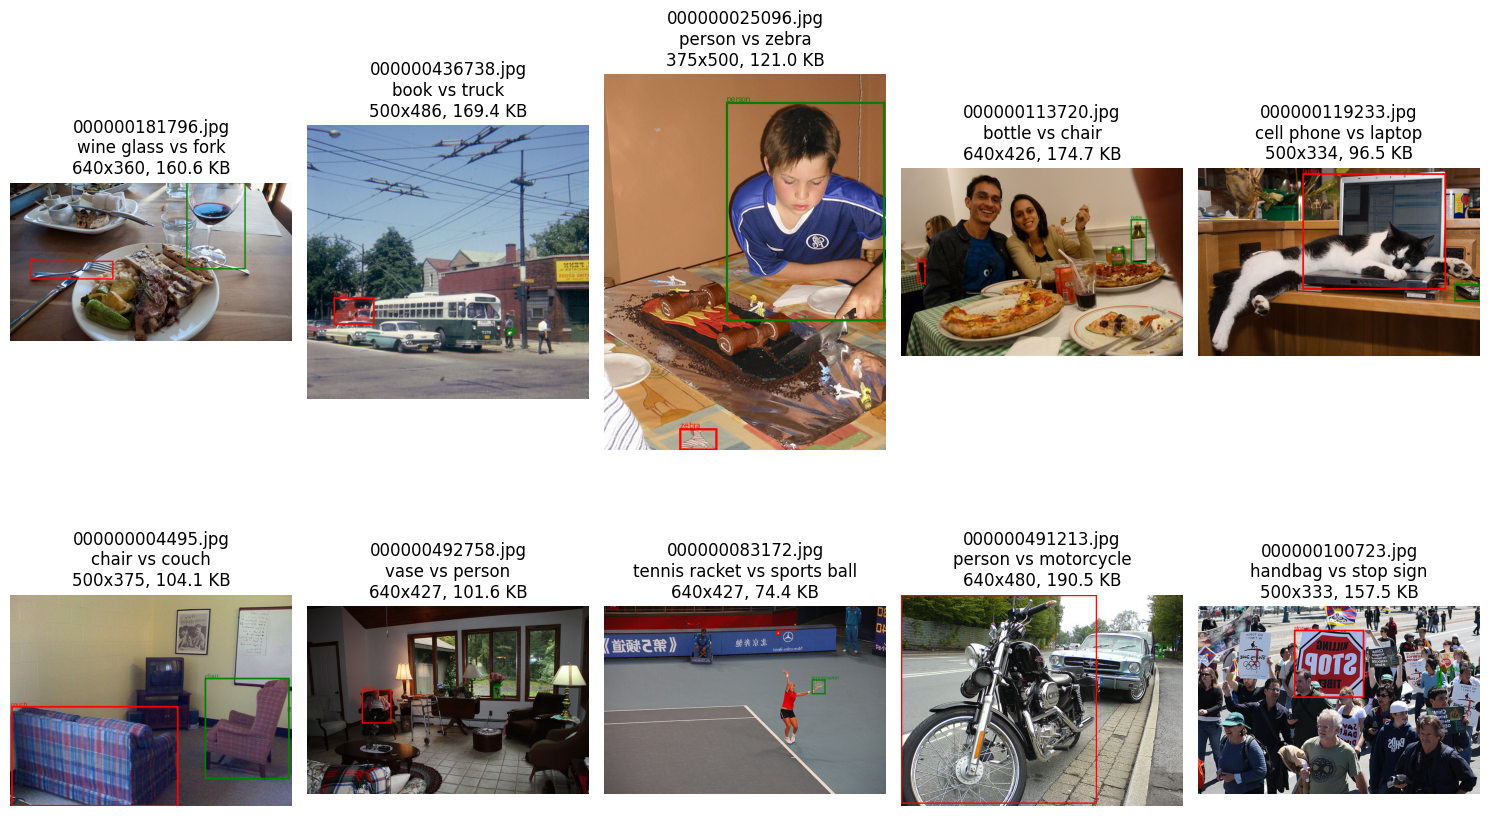

In [ ]:
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os

# Plot first 10 images with bounding boxes for left/right objects
fig = plt.figure(figsize=(15, 10))

for i, entry in enumerate(sampled_pairs[:10]):
    file_name = entry["file_name"]
    left_name = entry["left_object"]
    right_name = entry["right_object"]
    img_path = os.path.join(coco_folder, file_name)

    # Load image and metadata
    img = Image.open(img_path).convert("RGB")
    img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
    draw = ImageDraw.Draw(img_flipped)

    # Get image ID from file name
    image_id = file_name_to_id[file_name]
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    # Draw bounding boxes for left and right objects
    for ann in anns:
        name = coco.loadCats(ann["category_id"])[0]["name"]
        if name == left_name or name == right_name:
            x, y, w, h = ann["bbox"]
            # Flip x position for the flipped image
            flipped_x = img_flipped.width - x - w
            box = [flipped_x, y, flipped_x + w, y + h]
            color = "green" if name == left_name else "red"
            draw.rectangle(box, outline=color, width=3)
            draw.text((box[0], box[1] - 10), name, fill=color)

    # File info
    width, height = img_flipped.size
    file_size_kb = os.path.getsize(img_path) / 1024

    # Subplot
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img_flipped)
    ax.set_title(f"{file_name}\n{left_name} vs {right_name}\n{width}x{height}, {file_size_kb:.1f} KB")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
type(sampled_pairs)

list

In [ ]:
sampled_pairs[0]

{'image_id': 181796,
 'file_name': '000000181796.jpg',
 'left_object': 'wine glass',
 'right_object': 'fork'}

In [ ]:
# Clean response
def clean_response(response: str) -> str:
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1]
    elif "ASSISTANT" in response:
        response = response.split("ASSISTANT")[-1]
    return response.strip().lower()

def gt_compare_responses(response_original: str, response_flipped: str, gt_direction: str) -> dict:
    """
    gt_direction should be either 'left' or 'right', meaning the true direction of left_object vs right_object
    """
    original = clean_response(response_original)
    flipped = clean_response(response_flipped)

    # Flipped direction is opposite of ground truth
    flipped_gt = "right" if gt_direction == "left" else "left"

    print('Original: ', original)
    print('Flipped: ', flipped)
    print('GT original: ', gt_direction)
    print('GT flipped: ', flipped_gt)

    return {
        "Original": original == gt_direction,
        "Flipped": flipped == flipped_gt
    }

In [ ]:
len(sampled_pairs)

1000

In [ ]:
import hashlib

def should_swap(file_name):
    # Deterministic swap logic based on image file name
    h = hashlib.md5(file_name.encode()).hexdigest()
    return int(h, 16) % 2 == 0

In [ ]:
def symmetry_llava_coco(csv_path, sampled_pairs, viewer_centric):
    outputs = []

    for i, entry in enumerate(sampled_pairs):
        try:
            file_name = entry["file_name"]
            obj_a = entry["left_object"]
            obj_b = entry["right_object"]

            # Randomly decide which way to ask the question
            if should_swap(file_name):
                # Ask as-is: obj_a is to the left of obj_b
                prompt_left_obj = obj_a
                prompt_right_obj = obj_b
                gt_direction = "left"
            else:
                # Swap in the prompt: obj_b is to the left of obj_a
                prompt_left_obj = obj_b
                prompt_right_obj = obj_a
                gt_direction = "right"

            image_path = os.path.join(coco_folder, file_name)

            img_bgr = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)

            if viewer_centric:
                gt_direction = "right" if gt_direction == "left" else "left"
                prompt_template = f"""USER: <image>\nYou are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: {prompt_left_obj} and {prompt_right_obj}. One on the left side of the image and one to the right side of the image. Is the {prompt_left_obj} on the left side or the right side comparing it to the {prompt_right_obj} in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY.\nASSISTANT:"""
            else:
                prompt_template = f"""USER: <image>\nImagine that you are the {prompt_right_obj} in this image. Based on how things would appear from its point of view, is the {prompt_left_obj} to the left or right from you. Answer with just Left or Right ONLY.\nASSISTANT:"""
            print('Prompt: ', prompt_template)

            inputs = processor(images=img_pil, text=prompt_template, return_tensors="pt").to("cuda", torch.float16)

            output = model.generate(
              **inputs,
              max_new_tokens=200,
              do_sample=False
            )

            decoded = processor.batch_decode(output, skip_special_tokens=True)[0]

            # Clean response (remove echoing prompt)
            cleaned = decoded.replace(prompt_template.replace("<image>", "").strip(), "").strip()

            # Now, using flipped image
            img_pil_flipped = img_pil.transpose(method=Image.FLIP_LEFT_RIGHT)

            inputs_flipped = processor(images=img_pil_flipped, text=prompt_template, return_tensors="pt").to("cuda", torch.float16)
            output_flipped = model.generate(
              **inputs_flipped,
              max_new_tokens=200,
              do_sample=False
            )

            decoded_flipped = processor.batch_decode(output_flipped, skip_special_tokens=True)[0]

            # Clean response (remove echoing prompt)
            cleaned_flipped = decoded_flipped.replace(prompt_template.replace("<image>", "").strip(), "").strip()

            comparison = gt_compare_responses(cleaned, cleaned_flipped, gt_direction)

            comparison.update({
              "Image": file_name
            })

            outputs.append(comparison)

            # Append to CSV
            df = pd.DataFrame([comparison])  # wrap in list to make a 1-row dataframe
            if not os.path.exists(csv_path):
                df.to_csv(csv_path, index=False)
            else:
                df.to_csv(csv_path, mode="a", index=False, header=False)

            torch.cuda.empty_cache()
            print(f"Processed {file_name} ", i, "/", len(sampled_pairs))
        except Exception as e:
            print(f"⚠️ Error processing {file_name}: {str(e)}")
            continue

In [ ]:
csv_path = "llava_13b_sym_gtcoco_vc.csv"
symmetry_llava_coco(csv_path, sampled_pairs, viewer_centric = True)

Streaming output truncated to the last 5000 lines.
Prompt:  USER: <image>
You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: sports ball and baseball bat. One on the left side of the image and one to the right side of the image. Is the sports ball on the left side or the right side comparing it to the baseball bat in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY.
ASSISTANT:
Original:  left
Flipped:  left
GT original:  right
GT flipped:  left
Processed 000000383384.jpg  375 / 1000
Prompt:  USER: <image>
You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: cat and laptop. One on the left side of the image and one to the right side of the image. Is the cat on the left side or the right side comparing it to the laptop in the image? Use your own left and right as if you were sitting in front of the imag

In [ ]:
csv_path = "llava_13b_sym_gtcoco_ego.csv"
symmetry_llava_coco(csv_path, sampled_pairs, viewer_centric = False)

Streaming output truncated to the last 5000 lines.
Prompt:  USER: <image>
Imagine that you are the baseball bat in this image. Based on how things would appear from its point of view, is the sports ball to the left or right from you. Answer with just Left or Right ONLY.
ASSISTANT:
Original:  left
Flipped:  left
GT original:  left
GT flipped:  right
Processed 000000383384.jpg  375 / 1000
Prompt:  USER: <image>
Imagine that you are the laptop in this image. Based on how things would appear from its point of view, is the cat to the left or right from you. Answer with just Left or Right ONLY.
ASSISTANT:
Original:  left
Flipped:  left
GT original:  right
GT flipped:  left
Processed 000000519764.jpg  376 / 1000
Prompt:  USER: <image>
Imagine that you are the bottle in this image. Based on how things would appear from its point of view, is the cat to the left or right from you. Answer with just Left or Right ONLY.
ASSISTANT:
Original:  left
Flipped:  right
GT original:  left
GT flipped:  righ

# **GPT-4o**

## COCO GT

In [ ]:
api_key = ... # Include OpenAI api key

In [ ]:
# GPT
from io import BytesIO
import base64

from openai import OpenAI
client = OpenAI(api_key = api_key)

def encode_image_pil_to_base64(img_pil):
    buffered = BytesIO()
    img_pil.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def query_gpt4o(img_pil, prompt_template):
    image_base64 = encode_image_pil_to_base64(img_pil)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": [
                {"type": "text", "text": prompt_template},
                {"type": "image_url", "image_url": {
                    "url": f"data:image/png;base64,{image_base64}"
                }}
            ]}
        ],
        max_tokens=100,
    )
    return response.choices[0].message.content.strip()

def clean_response_gpt(response: str) -> str:
    response = response.strip().lower()
    if "left" in response:
        return "left"
    elif "right" in response:
        return "right"
    else:
        return "unclear"

def gt_compare_responses_gpt(response_original: str, response_flipped: str, gt_direction: str) -> dict:
    """
    gt_direction should be either 'left' or 'right', meaning the true direction of left_object vs right_object
    """
    original = clean_response_gpt(response_original)
    flipped = clean_response_gpt(response_flipped)

    # Flipped direction is opposite of ground truth
    flipped_gt = "right" if gt_direction == "left" else "left"

    print('Original: ', original)
    print('Flipped: ', flipped)
    print('GT original: ', gt_direction)
    print('GT flipped: ', flipped_gt)

    return {
        "Original": original == gt_direction,
        "Flipped": flipped == flipped_gt
    }

In [ ]:
# GPT
def symmetry_gpt_coco(csv_path, sampled_pairs, viewer_centric):
    outputs = []

    for i, entry in enumerate(sampled_pairs):
        try:
            file_name = entry["file_name"]
            obj_a = entry["left_object"]
            obj_b = entry["right_object"]

            # Randomly decide which way to ask the question
            if should_swap(file_name):
                # Ask as-is: obj_a is to the left of obj_b
                prompt_left_obj = obj_a
                prompt_right_obj = obj_b
                gt_direction = "left"
            else:
                # Swap in the prompt: obj_b is to the left of obj_a
                prompt_left_obj = obj_b
                prompt_right_obj = obj_a
                gt_direction = "right"

            image_path = os.path.join(coco_folder, file_name)

            img_bgr = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)

            if viewer_centric:
                gt_direction = "right" if gt_direction == "left" else "left"
                prompt_template = f"""You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: {prompt_left_obj} and {prompt_right_obj}. One on the left side of the image and one to the right side of the image. Is the {prompt_left_obj} on the left side or the right side comparing it to the {prompt_right_obj} in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY."""
            else:
                prompt_template = f"""Imagine that you are the {prompt_right_obj} in this image. Based on how things would appear from its point of view, is the {prompt_left_obj} to the left or right from you. Answer with just Left or Right ONLY."""
            print('Prompt: ', prompt_template)

            response = query_gpt4o(img_pil, prompt_template)

            # Now, using flipped image
            img_pil_flipped = img_pil.transpose(method=Image.FLIP_LEFT_RIGHT)
            response_flipped = query_gpt4o(img_pil_flipped, prompt_template)

            comparison = gt_compare_responses_gpt(response, response_flipped, gt_direction)
            comparison.update({
              "Image": file_name
            })

            outputs.append(comparison)

            # Append to CSV
            df = pd.DataFrame([comparison])  # wrap in list to make a 1-row dataframe
            if not os.path.exists(csv_path):
                df.to_csv(csv_path, index=False)
            else:
                df.to_csv(csv_path, mode="a", index=False, header=False)

            torch.cuda.empty_cache()
            print(f"Processed {file_name} ", i, "/", len(sampled_pairs))
        except Exception as e:
            print(f"⚠️ Error processing {file_name}: {str(e)}")
            continue

In [ ]:
csv_path = 'gpt4o_sym_vc.csv'
symmetry_gpt_coco(csv_path, sampled_pairs, viewer_centric = True)

Prompt:  You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: wine glass and fork. One on the left side of the image and one to the right side of the image. Is the wine glass on the left side or the right side comparing it to the fork in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY.
Original:  left
Flipped:  right
GT original:  right
GT flipped:  left
Processed 000000181796.jpg  0 / 1000
Prompt:  You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: truck and book. One on the left side of the image and one to the right side of the image. Is the truck on the left side or the right side comparing it to the book in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY.
Original:  right
Flipped:  left
GT original:  left
GT flipped:  right

KeyboardInterrupt: 

In [ ]:
csv_path = 'gpt4o_sym_ego.csv'
symmetry_gpt_coco(csv_path, sampled_pairs, viewer_centric = False)

Prompt:  Imagine that you are the fork in this image. Based on how things would appear from its point of view, is the wine glass to the left or right from you. Answer with just Left or Right ONLY.
Original:  left
Flipped:  right
GT original:  left
GT flipped:  right
Processed 000000181796.jpg  0 / 1000
Prompt:  Imagine that you are the book in this image. Based on how things would appear from its point of view, is the truck to the left or right from you. Answer with just Left or Right ONLY.
Original:  right
Flipped:  left
GT original:  right
GT flipped:  left
Processed 000000436738.jpg  1 / 1000
Prompt:  Imagine that you are the zebra in this image. Based on how things would appear from its point of view, is the person to the left or right from you. Answer with just Left or Right ONLY.
Original:  right
Flipped:  left
GT original:  left
GT flipped:  right
Processed 000000025096.jpg  2 / 1000
Prompt:  Imagine that you are the bottle in this image. Based on how things would appear from it

KeyboardInterrupt: 

## Symmetry: Is this image symmetrical?


In [ ]:
api_key = ... # Include OpenAI api key

In [ ]:
import os
import cv2
import pandas as pd
import traceback
from PIL import Image, ImageOps
from io import BytesIO
import base64
from openai import OpenAI

client = OpenAI(api_key = api_key)

sym_prompt_template = (
    "Is this image symmetrical along the vertical axis? "
    "In other words, is the left half of the image a mirror of the right half? "
    "Respond with only 'Yes' or 'No' or 'Unclear'."
)
csv_path = "gpt4o_symmetry_detection.csv"
outputs = []

def encode_image_pil_to_base64(img_pil):
    buffered = BytesIO()
    img_pil.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def query_gpt4o(img_pil, prompt_template):
    image_base64 = encode_image_pil_to_base64(img_pil)
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": [
                {"type": "text", "text": prompt_template},
                {"type": "image_url", "image_url": {
                    "url": f"data:image/png;base64,{image_base64}"
                }}
            ]}
        ],
        max_tokens=100,
    )
    return response.choices[0].message.content.strip()

def clean_response_symmetry(response: str) -> str:
    response = response.strip().lower()
    if "yes" in response:
        return "yes"
    elif "no" in response:
        return "no"
    else:
        return "unclear"

def compare_symmetry_responses(response_original: str, response_mirrored: str) -> dict:
    original = clean_response_symmetry(response_original)
    mirrored = clean_response_symmetry(response_mirrored)
    return {
        "Original_Response": original,
        "Mirrored_Response": mirrored,
        "Is_Consistent": original == mirrored or "unclear" in (original, mirrored)
    }


In [ ]:
# Define your image_files and coco_folder before this
for i, file_name in enumerate(image_files, start=1):
    try:
        image_path = os.path.join(coco_folder, file_name)
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        # Query for original image
        res_original = query_gpt4o(img_pil, sym_prompt_template)

        # Query for mirrored image
        img_mirrored = ImageOps.mirror(img_pil)
        res_mirrored = query_gpt4o(img_mirrored, sym_prompt_template)

        # Compare results
        result = compare_symmetry_responses(res_original, res_mirrored)
        result.update({
            "Image": file_name,
            "Original_Raw": res_original,
            "Mirrored_Raw": res_mirrored
        })

        outputs.append(result)

        df = pd.DataFrame([result])
        if not os.path.exists(csv_path):
            df.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, mode="a", header=False, index=False)

        print(f"Processed {file_name} ({i}/{len(image_files)})")

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        traceback.print_exc()

Processed 000000009483.jpg (1/500)
Processed 000000477227.jpg (2/500)
Processed 000000515828.jpg (3/500)
Processed 000000579655.jpg (4/500)
Processed 000000119516.jpg (5/500)
Processed 000000178982.jpg (6/500)
Processed 000000502168.jpg (7/500)
Processed 000000375015.jpg (8/500)
Processed 000000514376.jpg (9/500)
Processed 000000238866.jpg (10/500)
Processed 000000270386.jpg (11/500)
Processed 000000414510.jpg (12/500)
Processed 000000539883.jpg (13/500)
Processed 000000195045.jpg (14/500)
Processed 000000221291.jpg (15/500)
Processed 000000205542.jpg (16/500)
Processed 000000521141.jpg (17/500)
Processed 000000570471.jpg (18/500)
Processed 000000284282.jpg (19/500)
Processed 000000260266.jpg (20/500)
Processed 000000169996.jpg (21/500)
Processed 000000327306.jpg (22/500)
Processed 000000496722.jpg (23/500)
Processed 000000201418.jpg (24/500)
Processed 000000389315.jpg (25/500)
Processed 000000492282.jpg (26/500)
Processed 000000170613.jpg (27/500)
Processed 000000463618.jpg (28/500)
P

In [ ]:
len(image_files)

500

## Symmetry: Object Recognition

In [ ]:
object_prompt_template = (
    "What objects are visible in the image? "
    "Respond with a flat list of object names only, separated by commas (no extra description or full sentences)."
)

csv_path = "gpt4o_flip_obj_list.csv"
outputs = []


def get_object_list(response):
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1]
    elif "ASSISTANT" in response:
        response = response.split("ASSISTANT")[-1]
    cleaned = re.sub(r"[^\w\s,]", "", response)
    return set([obj.strip().lower() for obj in cleaned.split(",") if obj.strip()])

def compare_object_lists(objs, objs_flipped):
    intersection = objs & objs_flipped
    union = objs | objs_flipped
    return {
        "#Objects_Original": len(objs),
        "#Objects_Flipped": len(objs_flipped),
        "#Shared": len(intersection),
        "Jaccard": round(len(intersection) / len(union), 3) if union else 1.0,
        "ExactMatch": objs == objs_flipped,
        "MissingInFlipped": list(objs - objs_flipped),
        "ExtraInFlipped": list(objs_flipped - objs),
        "OriginalSet": objs,
        "FlippedSet": objs_flipped
    }



for i, file_name in enumerate(image_files, start=1):
    try:
        image_path = os.path.join(coco_folder, file_name)
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        # Query original image
        response_orig = query_gpt4o(img_pil, object_prompt_template)
        objs = get_object_list(response_orig)

        # Query mirrored image
        img_pil_flipped = ImageOps.mirror(img_pil)
        response_flipped = query_gpt4o(img_pil_flipped, object_prompt_template)
        objs_flipped = get_object_list(response_flipped)

        # Compare and log
        comparison = compare_object_lists(objs, objs_flipped)
        comparison.update({
            "Image": file_name,
            "Original_Raw": response_orig,
            "Flipped_Raw": response_flipped
        })

        outputs.append(comparison)
        df = pd.DataFrame([comparison])
        if not os.path.exists(csv_path):
            df.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, mode="a", header=False, index=False)

        print(f"Processed {file_name} ({i}/{len(image_files)})")

    except Exception as e:
        print(f"Error on file {file_name}: {e}")
        traceback.print_exc()


Processed 000000009483.jpg (1/500)
Processed 000000477227.jpg (2/500)
Processed 000000515828.jpg (3/500)
Processed 000000579655.jpg (4/500)
Processed 000000119516.jpg (5/500)
Processed 000000178982.jpg (6/500)
Processed 000000502168.jpg (7/500)
Processed 000000375015.jpg (8/500)
Processed 000000514376.jpg (9/500)
Processed 000000238866.jpg (10/500)
Processed 000000270386.jpg (11/500)
Processed 000000414510.jpg (12/500)
Processed 000000539883.jpg (13/500)
Processed 000000195045.jpg (14/500)
Processed 000000221291.jpg (15/500)
Processed 000000205542.jpg (16/500)
Processed 000000521141.jpg (17/500)
Processed 000000570471.jpg (18/500)
Processed 000000284282.jpg (19/500)
Processed 000000260266.jpg (20/500)
Processed 000000169996.jpg (21/500)
Processed 000000327306.jpg (22/500)
Processed 000000496722.jpg (23/500)
Processed 000000201418.jpg (24/500)
Processed 000000389315.jpg (25/500)
Processed 000000492282.jpg (26/500)
Processed 000000170613.jpg (27/500)
Processed 000000463618.jpg (28/500)
P

KeyboardInterrupt: 

# Last Model

## COCO GT

In [ ]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
claude_key = ... # Include Claude key to use API key

In [ ]:
from io import BytesIO
import base64
import os
import cv2
from PIL import Image
import pandas as pd
import torch
import anthropic

# Initialize Anthropic client
client = anthropic.Anthropic(api_key=claude_key)

def encode_image_pil_to_base64(img_pil):
    buffered = BytesIO()
    img_pil.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def query_claude(img_pil, prompt_template):
    image_base64 = encode_image_pil_to_base64(img_pil)

    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",  # You can choose other models like "claude-3-opus-20240229"
        max_tokens=100,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": image_base64
                        }
                    },
                    {
                        "type": "text",
                        "text": prompt_template
                    }
                ]
            }
        ]
    )
    return response.content[0].text

def clean_response_claude(response: str) -> str:
    response = response.strip().lower()
    if "left" in response:
        return "left"
    elif "right" in response:
        return "right"
    else:
        return "unclear"

def gt_compare_responses_claude(response_original: str, response_flipped: str, gt_direction: str) -> dict:
    """
    gt_direction should be either 'left' or 'right', meaning the true direction of left_object vs right_object
    """
    original = clean_response_claude(response_original)
    flipped = clean_response_claude(response_flipped)

    # Flipped direction is opposite of ground truth
    flipped_gt = "right" if gt_direction == "left" else "left"

    print('Original: ', original)
    print('Flipped: ', flipped)
    print('GT original: ', gt_direction)
    print('GT flipped: ', flipped_gt)

    return {
        "Original": original == gt_direction,
        "Flipped": flipped == flipped_gt
    }

# Claude version
def symmetry_claude_coco(csv_path, sampled_pairs, viewer_centric):
    outputs = []

    for i, entry in enumerate(sampled_pairs):
        try:
            file_name = entry["file_name"]
            obj_a = entry["left_object"]
            obj_b = entry["right_object"]

            # Randomly decide which way to ask the question
            if should_swap(file_name):
                # Ask as-is: obj_a is to the left of obj_b
                prompt_left_obj = obj_a
                prompt_right_obj = obj_b
                gt_direction = "left"
            else:
                # Swap in the prompt: obj_b is to the left of obj_a
                prompt_left_obj = obj_b
                prompt_right_obj = obj_a
                gt_direction = "right"

            image_path = os.path.join(coco_folder, file_name)

            img_bgr = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)

            if viewer_centric:
                gt_direction = "right" if gt_direction == "left" else "left"
                prompt_template = f"""You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: {prompt_left_obj} and {prompt_right_obj}. One on the left side of the image and one to the right side of the image. Is the {prompt_left_obj} on the left side or the right side comparing it to the {prompt_right_obj} in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY."""
            else:
                prompt_template = f"""Imagine that you are the {prompt_right_obj} in this image. Based on how things would appear from its point of view, is the {prompt_left_obj} to the left or right from you. Answer with just Left or Right ONLY."""
            print('Prompt: ', prompt_template)

            response = query_claude(img_pil, prompt_template)

            # Now, using flipped image
            img_pil_flipped = img_pil.transpose(method=Image.FLIP_LEFT_RIGHT)
            response_flipped = query_claude(img_pil_flipped, prompt_template)

            comparison = gt_compare_responses_claude(response, response_flipped, gt_direction)
            comparison.update({
              "Image": file_name
            })

            outputs.append(comparison)

            # Append to CSV
            df = pd.DataFrame([comparison])  # wrap in list to make a 1-row dataframe
            if not os.path.exists(csv_path):
                df.to_csv(csv_path, index=False)
            else:
                df.to_csv(csv_path, mode="a", index=False, header=False)

            torch.cuda.empty_cache()
            print(f"Processed {file_name} ", i, "/", len(sampled_pairs))
        except Exception as e:
            print(f"⚠️ Error processing {file_name}: {str(e)}")
            continue

In [ ]:
csv_path = 'claude_sym_vc.csv'
symmetry_claude_coco(csv_path, sampled_pairs, viewer_centric = True)

Streaming output truncated to the last 5000 lines.
GT flipped:  right
Processed 000000308799.jpg  166 / 1000
Prompt:  You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: dog and couch. One on the left side of the image and one to the right side of the image. Is the dog on the left side or the right side comparing it to the couch in the image? Use your own left and right as if you were sitting in front of the image. Answer with just Left or Right ONLY.
Original:  right
Flipped:  left
GT original:  left
GT flipped:  right
Processed 000000251572.jpg  167 / 1000
Prompt:  You are looking directly at the image on a screen, like a person viewing a photo. There are two main objects: sports ball and baseball bat. One on the left side of the image and one to the right side of the image. Is the sports ball on the left side or the right side comparing it to the baseball bat in the image? Use your own left and right as if you were sitting in

In [ ]:
from google.colab import files
files.download('claude_sym_vc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
csv_path = 'claude_sym_ego.csv'
symmetry_claude_coco(csv_path, sampled_pairs, viewer_centric = False)

Streaming output truncated to the last 5000 lines.
GT flipped:  left
Processed 000000308799.jpg  166 / 1000
Prompt:  Imagine that you are the couch in this image. Based on how things would appear from its point of view, is the dog to the left or right from you. Answer with just Left or Right ONLY.
Original:  left
Flipped:  left
GT original:  right
GT flipped:  left
Processed 000000251572.jpg  167 / 1000
Prompt:  Imagine that you are the baseball bat in this image. Based on how things would appear from its point of view, is the sports ball to the left or right from you. Answer with just Left or Right ONLY.
Original:  right
Flipped:  left
GT original:  right
GT flipped:  left
Processed 000000429690.jpg  168 / 1000
Prompt:  Imagine that you are the carrot in this image. Based on how things would appear from its point of view, is the knife to the left or right from you. Answer with just Left or Right ONLY.
Original:  right
Flipped:  left
GT original:  right
GT flipped:  left
Processed 0000

In [ ]:
from google.colab import files
files.download('claude_sym_ego.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_results = load_accuracy_data("path/to/csv/folder")
plot_accuracy_comparison(df_results)